# Classify the tiles using pretrained tile2vec
In this notebook we are going to measure the performance of classifier on EuroSATallbands dataset.

We will use model weights that are in the `/storage/tile2vec/models/`. Firstly we need to load the weights and create the embeddings of the tiles using our pretrained model.

## Load the model

Firstly we need to load the pretrained model. We use a simple function that loads the checkpoints.

In [23]:
import os
import torch
from pathlib import Path
import sys
sys.path.append("..")

import numpy as np
import pandas as pd

import pickle

from src.tilenet import make_tilenet


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()

def load_model(model_filepath, bands = 13, z_dim = 512):
    
    model_dir = Path('/storage/tile2vec/models')
    model_fn = model_dir / model_filepath # specify which model weights are to be loaded
    
    bands = bands # number of bands in the input data - should matche the model
    z_dim = z_dim # output dimension of the last layer of the encoder - should match the model


    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    cuda = torch.cuda.is_available()


    tilenet = make_tilenet(in_channels=bands, z_dim=z_dim) 
    if cuda: 
        tilenet.cuda()
        
    print("Model filepath: ", model_fn)

    checkpoint = torch.load(model_fn)
    tilenet.load_state_dict(checkpoint)
    tilenet.eval()
    print("Model succesfully loaded")
    return tilenet

In [2]:
tilenet = load_model(Path('TileNet_no_triplets_simple.ckpt'))

Model filepath:  /storage/tile2vec/models/TileNet_no_triplets_simple.ckpt
Model succesfully loaded


functions for visualization

In [24]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json

def vizualize_tsne_2d(X:np.ndarray, y:np.ndarray, text = "", **kwargs) -> None:
    # create tsne
    tsne = TSNE(n_components=2, **kwargs)
    tsne_result = tsne.fit_transform(X)

    tsne_result = pd.DataFrame(tsne_result)
    tsne_result

    # create dataframe to plot
    plot_data = pd.concat([pd.DataFrame(tsne_result), pd.DataFrame(y, columns=['label'])], axis = 1)

    # change numbers to meaningful text labels
    with open('/storage/EuroSATallBands/label_map.json') as f:
        label_map = json.load(f)
    reverse_label_map = {v:k for k, v in label_map.items()}
    reverse_label_map

    y_valtest_text = pd.Series(y).map(reverse_label_map)

    # plot tsne
    fig,ax = plt.subplots()
    for label in np.unique(plot_data['label']).tolist():
        x_plot,y_plot,lab = (plot_data.loc[plot_data['label']==label,0],plot_data.loc[plot_data['label']==label,1],plot_data.loc[plot_data['label']==label,'label'])
        ax.scatter(x_plot, y_plot, label = lab)
    ax.set_title(f"TSNE on tile2vec ({text})")
    ax.legend(np.unique(y_valtest_text), title = "Labels", bbox_to_anchor = (1.1,1.05))


def vizualize_tsne_3d(X:np.ndarray, y:np.ndarray, text = "") -> None:
    # create tsne
    tsne = TSNE(n_components=3)
    tsne_result = tsne.fit_transform(X)
    tsne_result = pd.DataFrame(tsne_result)

    # create dataframe to plot
    plot_data = pd.concat([pd.DataFrame(tsne_result), pd.DataFrame(y, columns=['label'])], axis = 1)

    # change numbers to meaningful text labels
    with open('/storage/EuroSATallBands/label_map.json') as f:
        label_map = json.load(f)
    reverse_label_map = {v:k for k, v in label_map.items()}
    reverse_label_map

    y_valtest_text = pd.Series(y).map(reverse_label_map)

    # plot tsne
    fig = plt.figure()
    ax = fig.add_subplot(projection = "3d")
    for label in np.unique(plot_data['label']).tolist():
        x_plot,y_plot,z_plot,lab = (plot_data.loc[plot_data['label']==label,0],
                    plot_data.loc[plot_data['label']==label,1],
                    plot_data.loc[plot_data['label']==label,2],
                    plot_data.loc[plot_data['label']==label,'label'])
        ax.scatter(x_plot, y_plot, z_plot, label = lab)
    ax.set_title(f"TSNE on tile2vec ({text})")
    ax.legend(np.unique(y_valtest_text), title = "Labels", bbox_to_anchor = (1.1,1.05))


## load the bare files and organize them into a dataframe

We need to load the files to perform evaluation. To evaluate performance of our trained unsupervised model, we need to perform a simple inference (forward pass) on the tiles and then create a classfier. Here we will use random forests and logistic regression. 

The classifier models will be trained using the embeddings from joined test and validation dataset. Because our dataset is quite well-balanced, our metric is set to be the accuracy measured using the 5-fold crossvalidation.

In [3]:
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from pathlib import Path
from src.data_utils import clip_and_scale_image

In [4]:
val_df = pd.read_csv("/storage/EuroSATallBands/validation.csv")
n_tiles = len(val_df)
tiles_path = Path("/storage/tile2vec/npy/val")

X_bare_val = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_val = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_val[index] = clip_and_scale_image(tile, img_type="landsat").flatten()
    X_bare_val[index] = tile.flatten()
    
y_val = val_df["Label"]

test_df = pd.read_csv("/storage/EuroSATallBands/test.csv")
n_tiles = len(test_df)
tiles_path = Path("/storage/tile2vec/npy/test")

X_bare_test = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_test = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_test[index] = clip_and_scale_image(tile, img_type="landsat").flatten()
    X_bare_test[index] = tile.flatten()
    
y_test = test_df["Label"]


train_df = pd.read_csv("/storage/EuroSATallBands/train.csv")
n_tiles = len(train_df)
tiles_path = Path("/storage/tile2vec/npy/train")

X_bare_train = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_train = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_train[index] =  clip_and_scale_image(tile, img_type="sentinel").flatten()

    X_bare_train[index] = tile.flatten()
    
y_train = train_df["Label"]

100%|██████████| 19317/19317 [00:12<00:00, 1552.57it/s]


In [5]:
y_train = train_df["Label"]
y_validation = val_df["Label"]
y_test = test_df["Label"]

In [6]:
X_norm_valtest = np.concatenate((X_norm_val, X_norm_test), axis=0)
y_valtest = np.concatenate((y_validation, y_test), axis=0)

We also want to compare our model with different methods of dimentionality reduction. Therefore we create variables to evaluate performance of different methods. In the code above we create 6 matrices, two for each part of our data. Each matrix contains observations from sets. For instance, X_*_train contains images as rows, which are flattened to a row-vector. Each collum contains information about pixel on a specific position in the image.

## Embeddings
Below there is a function that creates embeddings from the provided path and the model.

In [7]:

def create_embeddings_tile2vec(tilenet, 
                               df_filepath: str | Path, 
                               tiles_path: str | Path, 
                               img_type: str = "sentinel", 
                               bands: int = 13, 
                               z_dim: int = 512):
    """
    function creates matrix X and y containing embeddings and labels, loads the tiles from directory `tiles_path`
    """
    df_filepath = Path(df_filepath)
    tiles_path = Path(tiles_path)
    df = pd.read_csv(df_filepath)
    n_tiles = len(df)    
    
    X = np.zeros((n_tiles, z_dim))
    
    t0 = time()
    # this solution to iterate over examples is very suboptimal, one should use torch dataset
    for index in tqdm(range(n_tiles)):
        # read the tile from provided filepath
        
        tile = np.load(tiles_path / f"{index}.npy")  
        tile = clip_and_scale_image(tile, img_type=img_type)[:, :bands,:, :]
        tile = torch.from_numpy(tile).float()
        tile = (tile)
        if cuda: 
            tile = tile.cuda()
        z = tilenet.encode(tile)
        if cuda: 
            z = z.cpu()
        z = z.data.numpy()
        
        X[index,:] = z

    t1 = time()
    print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))
    
    y = df['Label'].values
    
    return X, y

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

rf = RandomForestClassifier()

In [9]:
def compare_results(X, y, model, folds = 5, model_name = ""):
    # simple method to evaluate performance of model using cross validation
    if model_name == "":
        model_name = model.__class__.__name__
    
    scores = cross_val_score(model, X, y, cv=folds)
    print("Averaged accuracy for model {}: {:.2f}±{:.2f}%".format(model_name, scores.mean()*100, scores.std()*100))

# Evaluation
Finally we perform tests, each section contains code and results of evaluation - the results and model or method type

## Contrastive loss - no modifications
margin = 0

In [10]:
X_validation, y_validation = create_embeddings_tile2vec(tilenet, "/storage/EuroSATallBands/validation.csv", "/storage/tile2vec/npy/val", img_type="landsat", bands=13, z_dim=512)
X_test, y_test = create_embeddings_tile2vec(tilenet, "/storage/EuroSATallBands/test.csv", "/storage/tile2vec/npy/test", img_type="landsat", bands=13, z_dim=512)

  0%|          | 0/5519 [00:00<?, ?it/s]

100%|██████████| 5519/5519 [00:21<00:00, 251.70it/s]


Embedded 5519 tiles: 21.929s


100%|██████████| 2759/2759 [00:10<00:00, 251.60it/s]

Embedded 2759 tiles: 10.968s


In [11]:
X = np.concatenate((X_validation, X_test), axis=0)  
y = np.concatenate((y_validation, y_test), axis=0)

In [12]:
compare_results(X, y, rf, folds = 5)

Averaged accuracy for model RandomForestClassifier: 44.07±0.62%


In [13]:
compare_results(X, y, lr, folds = 5)

/home/tymek/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/tymek/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Averaged accuracy for model LogisticRegression: 37.59±1.23%


/home/tymek/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'Heatmap of predictions')

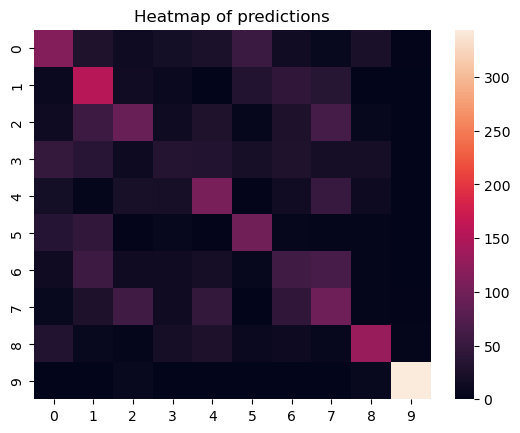

In [14]:
rf.fit(X_validation, y_validation)
y_pred = rf.predict(X_test)


sns.heatmap(confusion_matrix(y_test, y_pred))
plt.title("Heatmap of predictions")

In [15]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters = 10)

# check kmeans performance using completness and homogeneity

kmeans.fit(X_validation, y_validation)

y_pred = kmeans.predict(X_test)

from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score

print(f"V-measure score: {v_measure_score(y_test, y_pred)}")

from sklearn.metrics import silhouette_score

print("silhouette_score: ", silhouette_score(X_test, y_pred))

V-measure score: 0.25339309699184515
silhouette_score:  0.29879923310704526


## bigger regularization

In [16]:
tilenet = load_model(Path('TileNet_no_triplets_reg.ckpt'))

X_validation, y_validation = create_embeddings_tile2vec(tilenet, "/storage/EuroSATallBands/validation.csv", "/storage/tile2vec/npy/val", img_type="landsat", bands=13, z_dim=512)
X_test, y_test = create_embeddings_tile2vec(tilenet, "/storage/EuroSATallBands/test.csv", "/storage/tile2vec/npy/test", img_type="landsat", bands=13, z_dim=512)

Model filepath:  /storage/tile2vec/models/TileNet_no_triplets_reg.ckpt
Model succesfully loaded


100%|██████████| 5519/5519 [00:20<00:00, 263.74it/s]


Embedded 5519 tiles: 20.929s


100%|██████████| 2759/2759 [00:10<00:00, 254.32it/s]

Embedded 2759 tiles: 10.850s


In [17]:
X = np.concatenate((X_validation, X_test), axis=0)  
y = np.concatenate((y_validation, y_test), axis=0)

In [18]:
compare_results(X, y, rf, folds = 5)

Averaged accuracy for model RandomForestClassifier: 32.88±0.82%


In [19]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters = 10)

# check kmeans performance using completness and homogeneity

kmeans.fit(X_validation, y_validation)

y_pred = kmeans.predict(X_test)

from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score

print(f"V-measure score: {v_measure_score(y_test, y_pred)}")

from sklearn.metrics import silhouette_score

print("silhouette_score: ", silhouette_score(X_test, y_pred))

V-measure score: 0.12041866726885515
silhouette_score:  0.7937597796121116


Text(0.5, 0, 'Epoch')

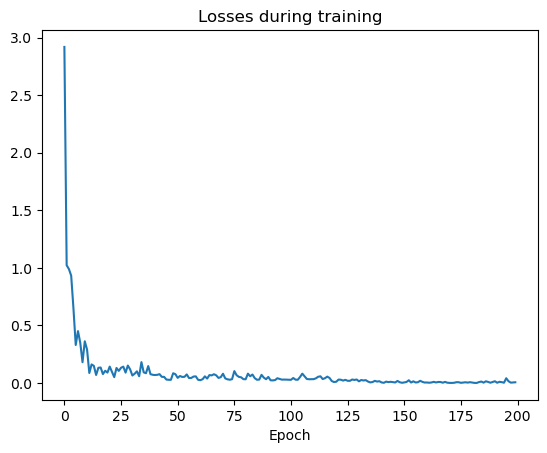

In [22]:
with open("/storage/tile2vec/results/TileNet_no_triplets_reg.ckpt.pkl", "rb") as f:
    progress = pickle.load(f)
    
progress = pd.DataFrame(progress)

progress["losses"].plot()
plt.title("Losses during training")
plt.xlabel("Epoch")

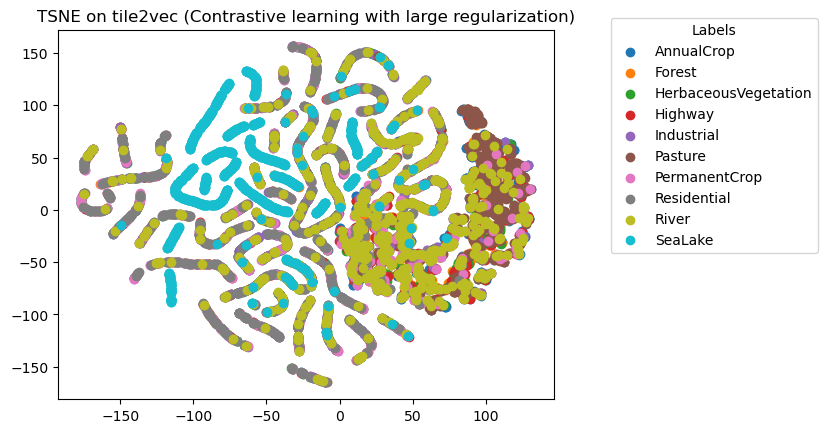

In [30]:
vizualize_tsne_2d(X, y, text = "Contrastive learning with large regularization", perplexity = 10, n_iter = 2000)

## Cosine loss

In [19]:
tilenet = load_model(Path('TileNet_no_triplets_cos.ckpt'))

X_validation, y_validation = create_embeddings_tile2vec(tilenet, "/storage/EuroSATallBands/validation.csv", "/storage/tile2vec/npy/val", img_type="landsat", bands=13, z_dim=512)
X_test, y_test = create_embeddings_tile2vec(tilenet, "/storage/EuroSATallBands/test.csv", "/storage/tile2vec/npy/test", img_type="landsat", bands=13, z_dim=512)

Model filepath:  /storage/tile2vec/models/TileNet_no_triplets_cos.ckpt
Model succesfully loaded


100%|██████████| 5519/5519 [00:18<00:00, 302.64it/s]


Embedded 5519 tiles: 18.243s


100%|██████████| 2759/2759 [00:08<00:00, 312.67it/s]

Embedded 2759 tiles: 8.826s


In [20]:
X = np.concatenate((X_validation, X_test), axis=0)  
y = np.concatenate((y_validation, y_test), axis=0)

In [21]:
compare_results(X, y, rf, folds = 5)

Averaged accuracy for model RandomForestClassifier: 44.79±0.98%


In [24]:
compare_results(X, y, lr, folds = 5)

/home/tymek/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/tymek/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Averaged accuracy for model LogisticRegression: 42.63±0.75%


/home/tymek/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters = 10)

# check kmeans performance using completness and homogeneity

kmeans.fit(X_validation, y_validation)

y_pred = kmeans.predict(X_test)

from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score

print(f"V-measure score: {v_measure_score(y_test, y_pred)}")

from sklearn.metrics import silhouette_score

print("silhouette_score: ", silhouette_score(X_test, y_pred))

V-measure score: 0.2568083413090104
silhouette_score:  0.33226997384938906


In [13]:
import pickle

with open("/storage/tile2vec/results/TileNet_no_triplets_cos.ckpt.pkl", "rb") as f:
    progress = pickle.load(f)

Text(0.5, 0, 'Epoch')

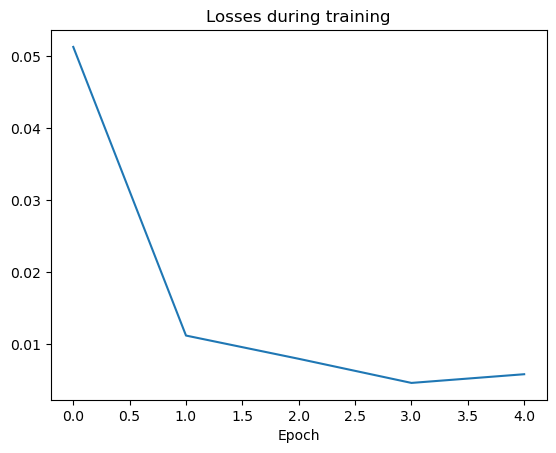

In [19]:
progress = pd.DataFrame(progress)

progress["losses"].plot()
plt.title("Losses during training")
plt.xlabel("Epoch")